In [955]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, GridSearchCV, LeaveOneGroupOut, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score
from sklearn.datasets import load_iris
from sklearn.preprocessing import Binarizer, LabelBinarizer
from sklearn.linear_model import LogisticRegression
from scipy.stats import shapiro, ttest_rel, stats

In [956]:
data = pd.read_csv('/Users/yuxuanzhang/Documents/1. semester/Projekt/Individuel/HR_data.csv')

data

,Unnamed: 0,HR_Mean,HR_Median,HR_std,HR_Min,HR_Max,HR_AUC,Round,Phase,Individual,Puzzler,Frustrated,Cohort
0,0,77.965186,78.000,3.345290,73.23,83.37,22924.945,round_3,phase3,1,1,1,D1_1
1,1,70.981097,70.570,2.517879,67.12,78.22,21930.400,round_3,phase2,1,1,5,D1_1
2,2,73.371959,73.360,3.259569,67.88,80.22,21647.085,round_3,phase1,1,1,0,D1_1
3,3,78.916822,77.880,4.054595,72.32,84.92,25258.905,round_2,phase3,1,1,1,D1_1
4,4,77.322226,74.550,6.047603,70.52,90.15,23890.565,round_2,phase2,1,1,5,D1_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,163,73.594539,72.380,9.474556,57.43,93.53,21482.985,round_4,phase2,14,0,8,D1_2
164,164,57.839897,54.130,6.796647,52.97,74.14,16825.740,round_4,phase1,14,0,0,D1_2
165,165,64.237295,65.195,3.589241,58.97,72.63,18691.065,round_1,phase3,14,0,1,D1_2
166,166,70.834320,70.440,2.391160,66.65,76.07,20753.005,round_1,phase2,14,0,4,D1_2


In [957]:
# Mean of the feature "Frustrated"
data['Frustrated'].mean()

2.2916666666666665

In [958]:
# Display basic information about the dataset
print(data.info())
print(data.describe())
print(data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  168 non-null    int64  
 1   HR_Mean     168 non-null    float64
 2   HR_Median   168 non-null    float64
 3   HR_std      168 non-null    float64
 4   HR_Min      168 non-null    float64
 5   HR_Max      168 non-null    float64
 6   HR_AUC      168 non-null    float64
 7   Round       168 non-null    object 
 8   Phase       168 non-null    object 
 9   Individual  168 non-null    int64  
 10  Puzzler     168 non-null    int64  
 11  Frustrated  168 non-null    int64  
 12  Cohort      168 non-null    object 
dtypes: float64(6), int64(4), object(3)
memory usage: 17.2+ KB
None
       Unnamed: 0     HR_Mean   HR_Median      HR_std      HR_Min      HR_Max  \
count  168.000000  168.000000  168.000000  168.000000  168.000000  168.000000   
mean    83.500000   76.009226   74.821458    6.041

/var/folders/jq/33048pbd5m3c98_pb4mlprqr0000gn/T/ipykernel_42861/1362498006.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=data['Frustrated'].value_counts().index,


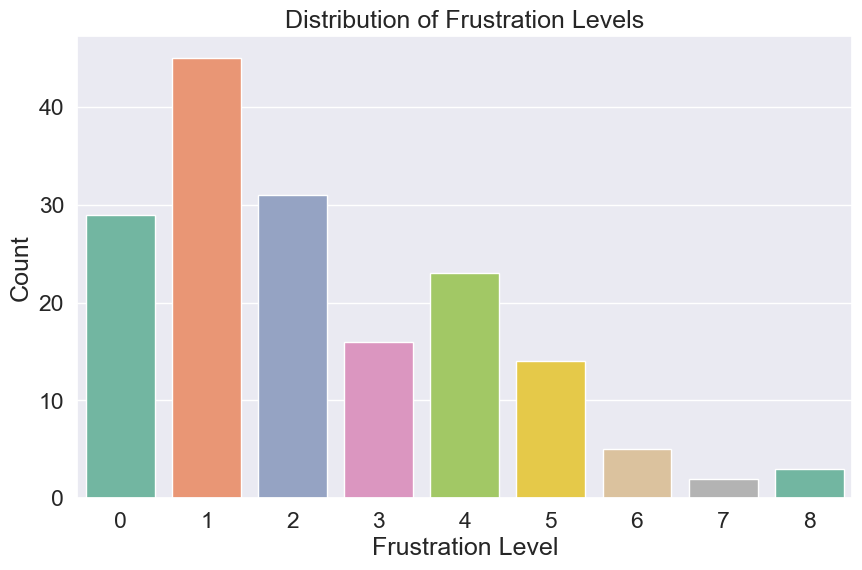

In [959]:
# Barplot of frustration level distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=data['Frustrated'].value_counts().index,
            y=data['Frustrated'].value_counts().values,
            palette="Set2")
plt.title('Distribution of Frustration Levels')
plt.xlabel('Frustration Level')
plt.ylabel('Count')
plt.show()

/var/folders/jq/33048pbd5m3c98_pb4mlprqr0000gn/T/ipykernel_42861/3946420214.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=data['Frustrated_Binarized'].value_counts().index,


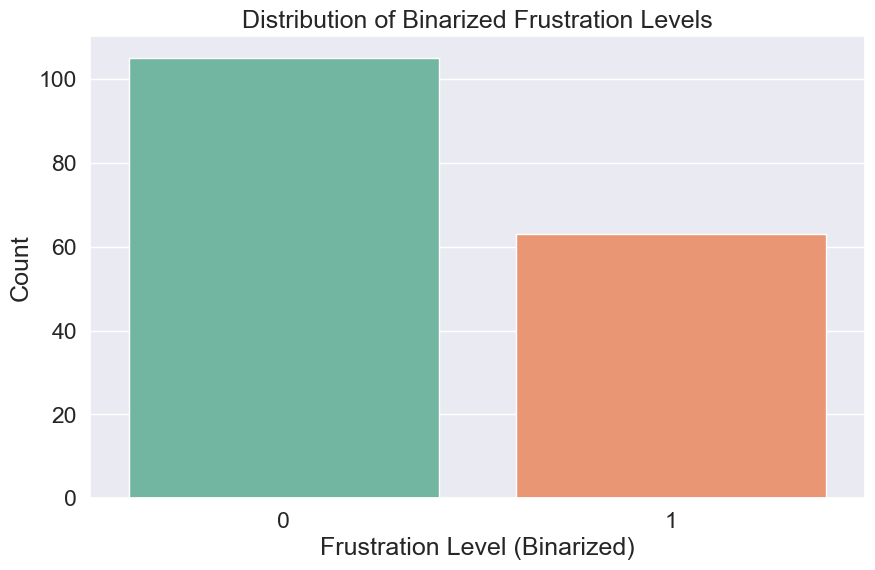

In [960]:

# Binarized frustration
threshold = 2.9166666
data['Frustrated_Binarized'] = (data['Frustrated'] > threshold).astype(int)
plt.figure(figsize=(10, 6))
sns.barplot(x=data['Frustrated_Binarized'].value_counts().index,
            y=data['Frustrated_Binarized'].value_counts().values,
            palette="Set2")
plt.title('Distribution of Binarized Frustration Levels')
plt.xlabel('Frustration Level (Binarized)')
plt.ylabel('Count')
plt.show()

In [961]:
# Binarize the target variable
threshold = 2.2916666666666665
y_bin = (y > threshold).astype(int)

# Initialize the LOGO cross-validator
logo = LeaveOneGroupOut()

# Range of n_estimators to test
n_estimators_range = [5, 10, 20, 50, 100, 200]

# Dictionary to store the average accuracies for each n_estimators
results = {}

# Iterate over different values of n_estimators
for n_estimators in n_estimators_range:
    accuracies = []
    model = RandomForestClassifier(n_estimators=n_estimators)
    
    # Perform LOGO cross-validation
    for train_index, test_index in logo.split(X, y_bin, groups):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y_bin.iloc[train_index], y_bin.iloc[test_index]
        
        # Train the model
        model.fit(X_train, y_train)
        
        # Evaluate the model
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)
    
    # Calculate the average accuracy
    average_accuracy = np.mean(accuracies)
    results[n_estimators] = average_accuracy
    print(f'n_estimators: {n_estimators}, Average Accuracy: {average_accuracy:.4f}')

# Find the best number of trees
best_n_estimators = max(results, key=results.get)
best_accuracy = results[best_n_estimators]

print(f'Best n_estimators: {best_n_estimators}, Best Accuracy: {best_accuracy:.4f}')

n_estimators: 5, Average Accuracy: 0.5595
n_estimators: 10, Average Accuracy: 0.5357
n_estimators: 20, Average Accuracy: 0.5476
n_estimators: 50, Average Accuracy: 0.5179
n_estimators: 100, Average Accuracy: 0.5298
n_estimators: 200, Average Accuracy: 0.5119
Best n_estimators: 5, Best Accuracy: 0.5595


In [962]:
# CROSS VALIDATION OF RANDOM FOREST CLASSIFIER
X = data[['HR_Mean', 'HR_Median', 'HR_std', 'HR_Min', 'HR_Max', 'HR_AUC']]
y = data['Frustrated']
groups = data['Individual']

# Binarize the target variable
threshold = 2.292
y_bin = (y > threshold).astype(int)

# Initialize the LOGO cross-validator
logo = LeaveOneGroupOut()

# Initialize the model
model = RandomForestClassifier(n_estimators=10)

# Lists to store results
accuracies = []

# Perform LOGO cross-validation
for train_index, test_index in logo.split(X, y_bin, groups):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y_bin.iloc[train_index], y_bin.iloc[test_index]
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Evaluate the model
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

    percentage_frustrated = np.mean(y_test) * 100
    print(f'Fold Test Set Percentage Frustrated: {percentage_frustrated:.2f}%')

# Calculate the average accuracy
average_accuracy = sum(accuracies) / len(accuracies)
print(f'Average Accuracy: {average_accuracy:.4f}')

stat, p_value = shapiro(accuracies)
stat, p_value

Fold Test Set Percentage Frustrated: 25.00%
Fold Test Set Percentage Frustrated: 33.33%
Fold Test Set Percentage Frustrated: 66.67%
Fold Test Set Percentage Frustrated: 41.67%
Fold Test Set Percentage Frustrated: 58.33%
Fold Test Set Percentage Frustrated: 50.00%
Fold Test Set Percentage Frustrated: 75.00%
Fold Test Set Percentage Frustrated: 33.33%
Fold Test Set Percentage Frustrated: 33.33%
Fold Test Set Percentage Frustrated: 8.33%
Fold Test Set Percentage Frustrated: 25.00%
Fold Test Set Percentage Frustrated: 25.00%
Fold Test Set Percentage Frustrated: 8.33%
Fold Test Set Percentage Frustrated: 41.67%
Average Accuracy: 0.5417


(0.875560998916626, 0.05026337876915932)

In [963]:
# CROSS VALIDATION OF LOGISTIC REGRESSION MODEL
X = data[['HR_Mean', 'HR_Median', 'HR_std', 'HR_Min', 'HR_Max', 'HR_AUC']]
y = data['Frustrated']
groups = data['Individual']

# Binarize the target variable
threshold = 2.292
y_bin = (y > threshold).astype(int)

# Initialize the LOGO cross-validator
logo = LeaveOneGroupOut()

# Initialize the model
model = LogisticRegression(max_iter=1000)

# Lists to store results
accuracies = []

# Perform LOGO cross-validation
for train_index, test_index in logo.split(X, y_bin, groups):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y_bin.iloc[train_index], y_bin.iloc[test_index]
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Evaluate the model
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

    percentage_frustrated = np.mean(y_test) * 100
    print(f'Fold Test Set Percentage Frustrated: {percentage_frustrated:.2f}%')

# Calculate the average accuracy
average_accuracy = np.mean(accuracies)
print(f'Average Accuracy: {average_accuracy:.4f}')

# Shapiro-Wilk test
stat, p_value = shapiro(accuracies)
print(f'Shapiro-Wilk Test: Statistic={stat:.4f}, p-value={p_value:.4f}')

Fold Test Set Percentage Frustrated: 25.00%
Fold Test Set Percentage Frustrated: 33.33%
Fold Test Set Percentage Frustrated: 66.67%
Fold Test Set Percentage Frustrated: 41.67%
Fold Test Set Percentage Frustrated: 58.33%
Fold Test Set Percentage Frustrated: 50.00%
Fold Test Set Percentage Frustrated: 75.00%
Fold Test Set Percentage Frustrated: 33.33%
Fold Test Set Percentage Frustrated: 33.33%
Fold Test Set Percentage Frustrated: 8.33%
Fold Test Set Percentage Frustrated: 25.00%
Fold Test Set Percentage Frustrated: 25.00%
Fold Test Set Percentage Frustrated: 8.33%
Fold Test Set Percentage Frustrated: 41.67%
Average Accuracy: 0.5714
Shapiro-Wilk Test: Statistic=0.9092, p-value=0.1536


/var/folders/jq/33048pbd5m3c98_pb4mlprqr0000gn/T/ipykernel_42861/3350617615.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Model', y='Score', data=data, palette='Set2')


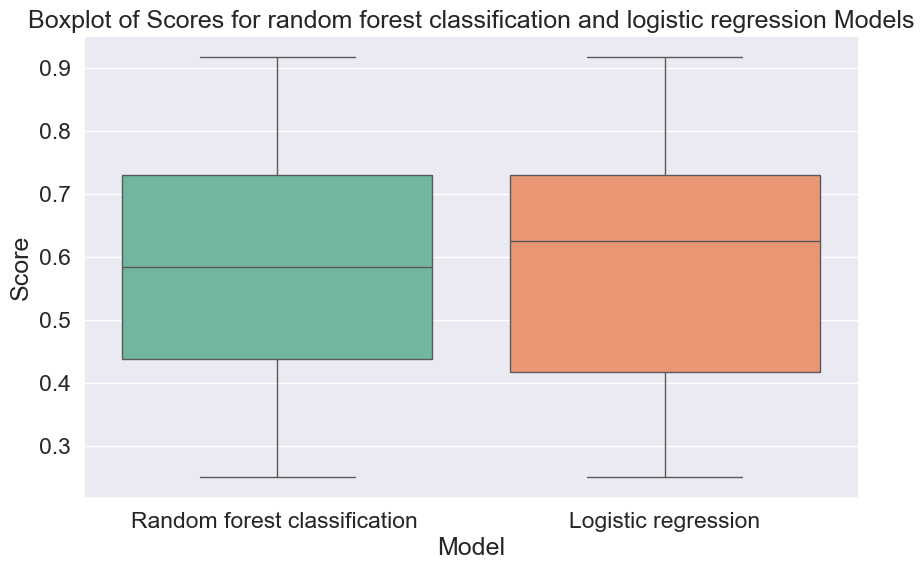

Paired t-test: t-statistic=0.3851, p-value=0.7064


In [964]:
RFC =[0.9166666666666666, 0.4166666666666667, 0.25, 0.6666666666666666, 
      0.5833333333333334, 0.5, 0.3333333333333333, 0.5833333333333334, 0.5, 
      0.8333333333333334, 0.6666666666666666, 0.75, 0.4166666666666667, 0.75]
LR=[0.6666666666666666, 0.6666666666666666, 0.25, 0.3333333333333333, 
    0.4166666666666667, 0.4166666666666667, 0.25, 0.75, 0.6666666666666666, 
    0.9166666666666666, 0.8333333333333334, 0.75, 0.4166666666666667, 0.5833333333333334]

t_stat, p_value = ttest_rel(RFC, LR)

# Prepare data for plotting
data = pd.DataFrame({'Random forest classification ': RFC, 'Logistic regression': LR})
data = data.melt(var_name='Model', value_name='Score')

# Create boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Model', y='Score', data=data, palette='Set2')
plt.title('Boxplot of Scores for random forest classification and logistic regression Models')
plt.xlabel('Model')
plt.ylabel('Score')
plt.show()

print(f'Paired t-test: t-statistic={t_stat:.4f}, p-value={p_value:.4f}')

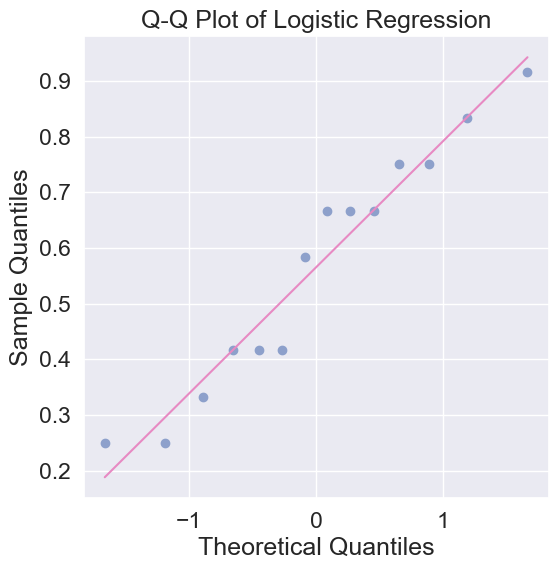

In [965]:
import scipy.stats as stats

# Given data for Logistic Regression
LR = [0.6666666666666666, 0.6666666666666666, 0.25, 0.3333333333333333, 0.4166666666666667, 
      0.4166666666666667, 0.25, 0.75, 0.6666666666666666, 0.9166666666666666, 0.8333333333333334, 
      0.75, 0.4166666666666667, 0.5833333333333334]

sns.set_palette("Set2")

# Q-Q plot for Logistic Regression
plt.figure(figsize=(6, 6))
ax = plt.gca()
res = stats.probplot(LR, dist="norm", plot=ax)
ax.get_lines()[0].set_color(sns.color_palette("Set2")[2])  # Q-Q plot points
ax.get_lines()[1].set_color(sns.color_palette("Set2")[3])  # Q-Q plot line
plt.title('Q-Q Plot of Logistic Regression')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.show()

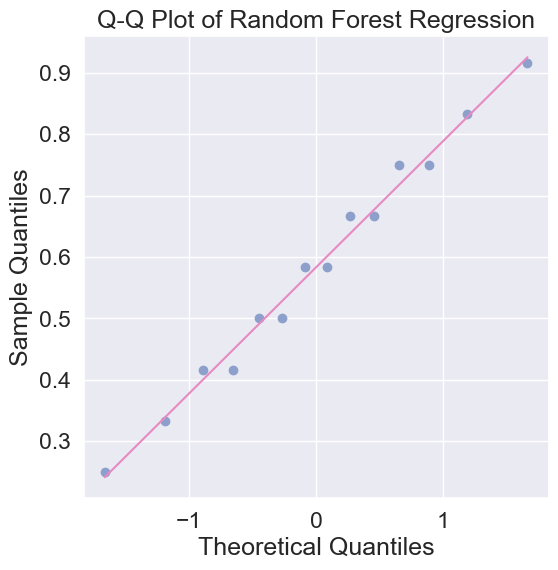

In [966]:
# Given data for Logistic Regression
RFC =[0.9166666666666666, 0.4166666666666667, 0.25, 0.6666666666666666, 0.5833333333333334, 0.5, 
      0.3333333333333333, 0.5833333333333334, 0.5, 0.8333333333333334, 
      0.6666666666666666, 0.75, 0.4166666666666667, 0.75]

sns.set_palette("Set2")

# Q-Q plot for Random Forest Regression
plt.figure(figsize=(6, 6))
ax = plt.gca()
res = stats.probplot(RFC, dist="norm", plot=ax)
ax.get_lines()[0].set_color(sns.color_palette("Set2")[2])  # Q-Q plot points
ax.get_lines()[1].set_color(sns.color_palette("Set2")[3])  # Q-Q plot line
plt.title('Q-Q Plot of Random Forest Regression')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.show()